# Solving a PDE: Schrödinger Equation

In [2]:
import numpy as np
from scipy.constants import hbar, electron_mass as me, proton_mass as mp
from scipy.integrate import fixed_quad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

## 1. Plotting initial conditions.

In [126]:
# Initial conditions, outside for plotting.
f_re = lambda x: amp*np.exp(-(x-xc)**2.0/s)*np.cos(2.0*np.pi*(x-xc)/wl)
f_im = lambda x: amp*np.exp(-(x-xc)**2.0/s)*np.sin(2.0*np.pi*(x-xc)/wl)

<IPython.core.display.Javascript object>


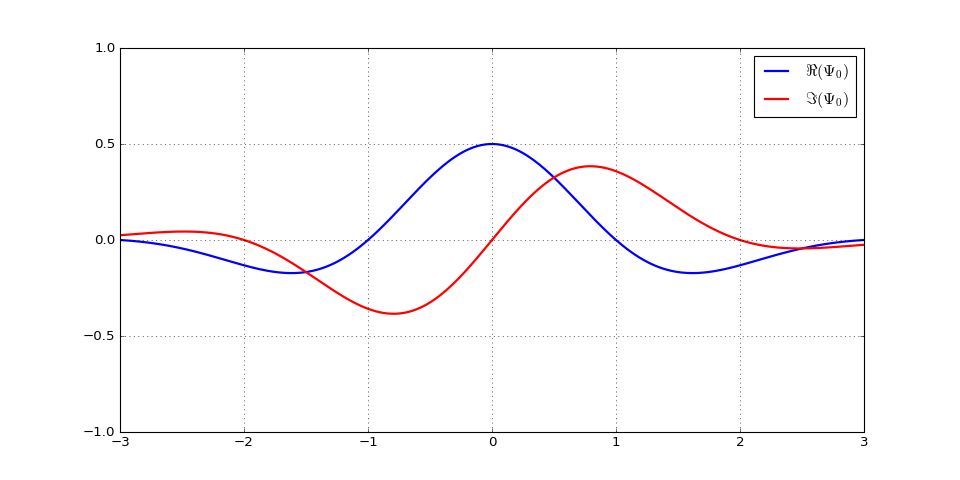

In [140]:
# Center of wave
xc = 0
# Wavelength
wl = 4
# Exponential decay coeficient
s = 3
# Amplitude
amp = 0.5

xx = np.linspace(-3, 3, 400)
yy_re = f_re(xx)
yy_im = f_im(xx)

plt.figure(figsize=(12,6))
plt.ylim(-1, 1)
plt.plot(xx, yy_re, 'b-', lw=2.0, label=r"$\Re(\Psi_0)$")
plt.plot(xx, yy_im, 'r-', lw=2.0, label=r"$\Im(\Psi_0)$")
plt.grid(True)
plt.legend(loc='best')
plt.draw()

## 2. Applying numerical knowledge

Implementing a solver for the equation. Notice that we splited the real part and imaginary part.

In [220]:
def schroedinger1D(xl, xr, yb, yt, M, N, D, xc, wl, s, amp):
    """
        Schrödinger Equation Simulation (with no potential, i.e. V(x,t) = 0)
        Args:
            [xl, xr]:    Space interval
            [yb, yt]:    Time interval
            M, N:        Space and time steps
            D:           Custom coefficient (should be hbar/(2m))
            xc:          Center for initial condition
            wl:          Wavelength for initial condition
            s:           Decay for initial condition
            amp:         Amplitude for initial condicion
    """
    # Normalize wave
    f = lambda x: f_re(x)**2 + f_im(x)**2
    area = fixed_quad(f, xl, xr, n=5)[0]
    f_real = lambda x: f_re(x)/area
    f_imag = lambda x: f_im(x)/area
    # Boundary conditions for all t
    l = lambda t: 0*t
    r = lambda t: 0*t
    # Effective mass
    #m = mp*me/(mp+me)
    # "Diffusion coefficient"
    #D = hbar / (2*m)
    # Step sizes and sigma constant
    h, k = (xr-xl)/M, (yt-yb)/N
    m, n = M-1, N
    sigma = D*k/(h**2)
    print("k=%f" % k)
    print("h=%f" % h)
    print("Sigma=%f" % sigma)
    # Finite differences matrix
    A_real = np.diag(2*sigma*np.ones(m)) + np.diag(-sigma*np.ones(m-1),1) + np.diag(-sigma*np.ones(m-1),-1)
    A_imag = -A_real
    # Left boundary condition u(xl,t) from time yb
    lside = l(yb+np.arange(0,n)*k)
    # Right boundary condition u(xr,t) from time tb
    rside = r(yb+np.arange(0,n)*k)
    # Initial conditions
    W_real = np.zeros((m, n))
    W_imag = np.zeros((m, n))
    W_real[:,0] = f_real(xl + np.arange(0,m)*h)
    W_imag[:,0] = f_imag(xl + np.arange(0,m)*h)
    # Solving for imaginary and real part
    for j in range(0,n-1):
        b_cond = np.concatenate(([lside[j]], np.zeros(m-2), [rside[j]]))
        W_real[:,j+1] =  W_real[:,j] + A_real.dot(W_imag[:,j]) - sigma*b_cond
        W_imag[:,j+1] =  W_imag[:,j] + A_imag.dot(W_real[:,j]) + sigma*b_cond
    print("System solved.")
    return np.vstack([lside, W_real, rside]).T, np.vstack([lside, W_imag, rside]).T

In [228]:
xl, xr, yb, yt, M, N, D, xc, wl, s, amp = (-3, 3, 0, 4, 16, 2000, 1.0, 0, 4.0, 3.0, 1.0)
W_real, W_imag = schroedinger1D(xl, xr, yb, yt, M, N, D, xc, wl, s, amp)

k=0.002000
h=0.375000
Sigma=0.014222
System solved.


## 3. Plot results

<IPython.core.display.Javascript object>


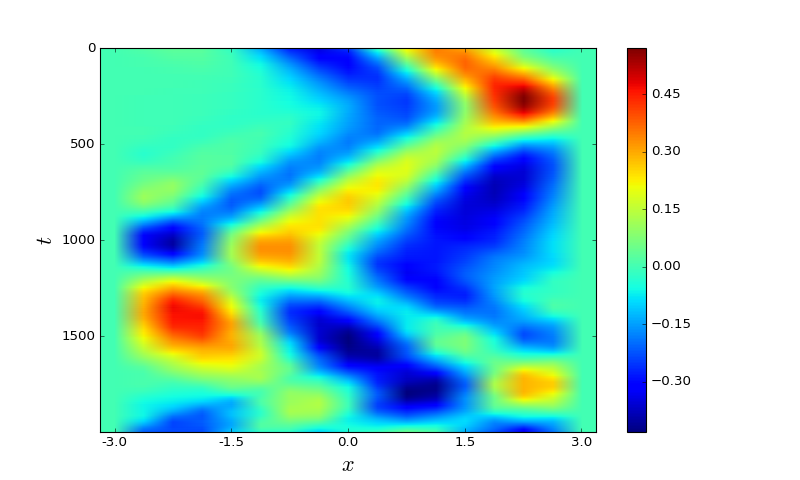

In [229]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
matrix = ax.imshow(W_imag, aspect='auto')
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$t$", fontsize=20)
ax.set_xticks(np.linspace(0,M,5))
ax.set_xticklabels(np.linspace(xl,xr,5))
fig.colorbar(matrix)
plt.draw()

<IPython.core.display.Javascript object>


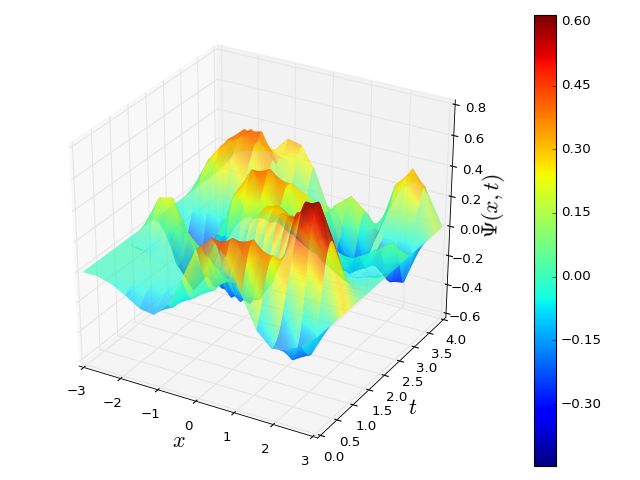

In [232]:
[X, T] = np.meshgrid(np.linspace(xl, xr, M+1), np.linspace(yb, yt, N))
# Plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$t$", fontsize=20)
ax.set_zlabel("$\Psi(x,t)$", fontsize=20)
ax.set_xlim(xl, xr)
surface = ax.plot_surface(X, T, W_real, cmap=cm.jet, linewidth=0, antialiased=True, rstride=1, cstride=1)
fig.colorbar(surface)
plt.tight_layout()
plt.draw()